<a href="https://colab.research.google.com/github/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepTC - Statistics of the Dataset

This is the second Colab notebook for deepTC, and the objective of deepTC can be found on [deepTC github page](https://github.com/aachen6/deepTC/) for the first reader. The first notebook described the extraction of the best track and satellite images of historical TCs, which are synchronized into a seamless dataset and archived on my Google Drive. A version of copy can be found on the [deepTC githubt page](https://github.com/aachen6/deepTC/). This notebook will explore the dataset to get some basic understanding. 

1. [Satellite images and tracks of TCs](https://)

2. **[Statistics of satellite images and tracks](https://)**

3. [Post-binding architecture for deepTC](https://)

4. [CNN model for deepTC](https://)

5. [Resnet model for deepTC](https://)

6. [GAN model for deepTC](https://)

7. [LSTM model for deepTC](https://)
 
8. [LSTM-CNN model for deepTC](https://)


Let's get started by loading some python modules,  mounting the google drive, and set the directory for the data.

In [0]:
# basic module
import os
import yaml
import numpy as np
import pandas as pd 

# file and plot management
import seaborn as sns
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/deepTC'
p_data = path + os.sep + 'data/AL'
p_image = path + os.sep + 'image/AL'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Satellite Image Samples

Then, let's take a look at some sample satellite images, which are manually selected from Katrina in 2005 with one respresenting each catergory. It seems from this sample set that each catergory shows certain unique pattern. The differences are not always this apparent and could be very subtle to nake eyes. It's also noticed that quite a few images contain high percentage of black pixels, see image in the bottom middle, which will be removed from the dataset based on the percentage (5%) of black pixels for simplicity. The last image shows histograms from RGB channels, which are very similar. The differences are likely only due to the color grid line and/or the shoreline. They are also well center-balanced leaning slightly towards the dark end, while bright portion picks up based on the storm cloud intensity.

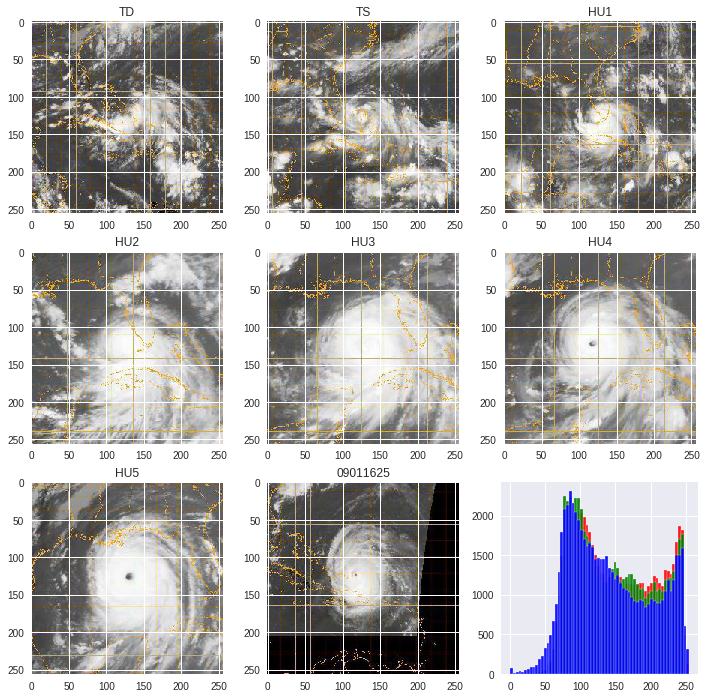

In [0]:
f_images = []
p_sample = p_image + os.sep + "samples"
for root, folders, files in os.walk(p_sample):
  for f_name in sorted(files):
    f_image = os.path.join(root, f_name)
    f_images.append(f_image) 

nax = 0
f, axes = plt.subplots(3, 3, figsize=(12, 12))
for row in axes:
  for ax in row:
    if nax<8:
      f_image = f_images[nax]
      label = f_image.split(".")[0].split("_")[-1]
      image = Image.open(f_image)
      if nax==6: image_h5 = image
      ax.imshow(image)
      ax.set_title(label)
    else:
      values = np.array(image_h5)
      for j, c in enumerate(["r","g","b"]):
        v = values[:,:,j].flatten()
        ax.hist(v, bins=64, range=(0, 255), fc=c, ec='w', alpha=0.9)
    nax = nax + 1

##Satellite Image Statistics

The best track data Hurdat2 contains following categories of the storm status:

* TD – Tropical cyclone of tropical depression intensity (< 34 knots)
* TS – Tropical cyclone of tropical storm intensity (34-63 knots)
* HU – Tropical cyclone of hurricane intensity (> 64 knots)
* EX – Extratropical cyclone (of any intensity)
* SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
* SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
* LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
* DB – Disturbance (of any intensity) 

Let's look at the statistics of the classifcations using a bar plot.The dataset is extremely unbalanced with almost half of the images being TS. 

In [0]:
#coding:utf-8

f_raw = p_data + os.sep + "al_ir_track.msg" 
pd_raw = pd.read_msgpack(f_raw)

pd_raw[b"cat"] = pd_raw[b"cat"].str.decode("utf-8")
count_raw = pd_raw.groupby(b"cat").count().reset_index()
count_raw = count_raw.sort_values(b"storm", ascending=False)

f, ax = plt.subplots()
ax.set_title("raw")
sns.barplot(x=b"cat", y=b"storm", data=count_raw, ax=ax)


To improve the balance of the dataset, images with category EX, SD, SS, LO, and DB are firstly filtered since the objective is for TCs. Further, TCs that never reached to a hurricane intensity during their lifetime were also filtered. After applying the filter to the satellite image set, the statistics of the classifcations are replotted. Although the balance is greatly improved, the number of samples for each category is still biased. Let's move on for now, but this should be kept in mind when interpreting the accuary of the model. 

In [0]:
"""

# The filtered file has been generated

# remove weak storms that do not reach a hurricane level
storms = set(pd_raw["storm"].tolist())
for storm in set(pd_raw["storm"].tolist()):
  pd_storm = pd_raw[pd_raw["storm"]==storm]
  sub_cats = set(pd_storm["cat"].tolist())
  common = sub_cats & set(["HU1", "HU2", "HU3", "HU4", "HU5"])
  if len(common)==0: storms.remove(storm)
pd_sub = pd_raw[pd_raw["cat"].isin(cats)]
pd_sub = pd_sub[pd_sub["storm"].isin(storms)]


filtered = [] # filter images with greater than 5% black pixels
for index, row in pd_sub.iterrows():
  try:
    f_image = os.getcwd() + r"\image\AL" + os.sep + row["image"]
    img = Image.open(f_image)
    img = np.array(img)
    pct = np.count_nonzero(img)/float(img.size)  
    if pct<0.95: continue 
    key = row["storm"] + row["date"].strftime("%m%d%H%M")
    filtered.append([key, row["cat"], row["image"]])
  except:
    continue 

f_filter = p_data + os.sep + "al_ir_track_filtered.msg"    
pd_filter = pd.DataFrame(filtered, columns=["key","cat","image"]) 
pd_filter.to_msgpack(f_filter)

"""

f_filter = p_data + os.sep + "al_ir_track_filtered.msg"    
pd_filter = pd.read_msgpack(f_filter)
pd_filter[b"cat"] = pd_filter[b"cat"].str.decode("utf-8")

count_filter = pd_filter.groupby(b"cat").count().reset_index()
count_filter = count_filter.sort_values(b"key", ascending=False)

f, ax = plt.subplots()
ax.set_title("filtered")
bar = sns.barplot(x=b"cat", y=b"key", data=count_filter, ax=ax)
for i, (index, row) in enumerate(count_filter.iterrows()):
    bar.text(i, row[b"key"]+200, row[b"key"], color='black', ha="center")


##Normalization

It's necessary to derive the mean and standard deviation of the input dataset for normalization. A naive calculation may not work due to signicant amount of data with large feature size. The following function computes synthetic mean and standard deviation of two samples from their respective mean and standard deviation. The mean and standard deviation used for normalization should be calculated over the training set. Here we only shows an example that is generated with the first 1000 images. 

In [0]:
def normalization_factor(sample_a, sample_b):
  (n_a, mean_a, std_a) = sample_a
  (n_b, mean_b, std_b) = sample_b
  
  n_c = n_a + n_b
  mean_c = n_a*mean_a + n_b*mean_b
  mean_c = mean_c/n_c
  
  numerator = (n_a-1)*std_a**2. + (n_b-1)*std_b**2. + \
              n_a*(mean_a-mean_c)**2. + n_b*(mean_b-mean_c)**2.
  
  denorminator = n_c - 1
  
  std_c = np.sqrt(numerator/denorminator)
  
  return np.array([n_c, mean_c, std_c])

counter = 0
f_img_zip = p_image + os.sep + "AL.zip"
img_archv = ZipFile(f_img_zip, "r")
for f_img in img_archv.namelist(): 
  image = Image.open(img_archv.open(f_img))
  image = np.array(image)
  mean = np.mean(image, axis=(0,1))
  std  = np.std(image, axis=(0,1))
  if counter==0:
    shp = image.shape
    n = np.full(shp[2], shp[0]*shp[1])
    sample_a = (n, mean, std)
  else:
    sample_b = (n, mean, std)
    sample_a = normalization_factor(sample_a, sample_b)

  counter = counter + 1
  if counter%1000==0: 
    print("mean and standard deviation drawn from {0:n} images are: ".format(counter))
    print("mean = ", sample_a[1]/255)
    print("std = ", sample_a[2]/255)
    break

mean and standard deviation drawn from 1000 images are: 
mean =  [0.45670129 0.45670129 0.45670129]
std =  [0.22167495 0.22167495 0.22167495]
